In [1]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
# LMU is not a rwal university <3
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""

"\n#Amount google drive\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\n# LMU is not a rwal university <3\nprint(sorted(os.listdir()))\n\n#!pip install lightning\n#!pip install omegaconf\n"

In [2]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [3]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(name_dataset, name_model, use_test_set=False, seed=0):
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping.lower() == 'linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping.lower() == 'affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping.lower() == 'neuralnetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [4]:
##############################################
#Specify here which files you want to use
#Sorry but this fucking thing of the path is ALWAYS broken for me unless I do this. REMOVE when you run this notebook
os.chdir("/Users/federicoferoggio/Documents/vs_code/latent-communication")

#changed the processing of the file: It reads all the transomrations available given cerain filters. It should be possible to pass a single file.
directory_to_explore = 'results/transformations/mapping_files/PCKTAE'
results_list = os.listdir(directory_to_explore)
filters =  ['FMNIST']
results_dataframe  = []
results_dataframe_by_classes = []
###############################################
##Sort the result list
results_list = sorted(results_list)
## Parameters of the iteraction before to avoid repeated loading
data_info_1_old, data_info_2_old, name_dataset1_old, name_dataset2_old = None, None, None, None
criterion = nn.MSELoss()
for file in tqdm(results_list):
    file = file[:-4]
    for filter in filters:
        if filter.lower() in file.lower():
            data_info_1, data_info_2, trans_info = file.split(">")
            
            if name_dataset1_old != data_info_1.split("_")[0]:
                name_dataset1, name_model1, size_of_the_latent1, seed1 = data_info_1.split("_")
                images, labels, n_classes = define_dataloader(name_dataset1, name_model1, seed=seed1, use_test_set=True)
                images = images.to(DEVICE).float()  # Ensure float32
                labels = labels.to(DEVICE)

            if data_info_1_old != data_info_1:
                name_dataset1, name_model1, size_of_the_latent1, seed1 = data_info_1.split("_")
                file1 = f'models/checkpoints/{name_model1}/{name_dataset1}/{name_dataset1}_{name_model1}_{size_of_the_latent1}_{seed1}.pth'
                model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=size_of_the_latent1, seed=seed1, model_path=file1).to(DEVICE)
                latent_left = model1.get_latent_space(images).detach().cpu().numpy().astype('float32')  # Ensure float32
                
            if data_info_2_old != data_info_2:
                name_dataset2, name_model2, size_of_the_latent2, seed2 = data_info_2.split("_")
                file2 = f'models/checkpoints/{name_model2}/{name_dataset2}/{name_dataset2}_{name_model2}_{size_of_the_latent2}_{seed2}.pth'
                model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=size_of_the_latent2, seed=seed2, model_path=file2).to(DEVICE)
                latent_right = model2.get_latent_space(images).to(DEVICE).float()  # Ensure float32
                
            list_info_trans = trans_info.split("_")
            mapping_name, num_samples, lamda_t = list_info_trans.pop(0), list_info_trans.pop(0), list_info_trans.pop(0)
            sampling_strategy = "_".join(list_info_trans)
            mapping = load_mapping(directory_to_explore + "/" + file, mapping_name)
            transformed_latent_space = torch.tensor(mapping.transform(latent_left), dtype=torch.float32).to(DEVICE)  # Ensure float32
            
            decoded = model2.decode(latent_right).to(DEVICE).float()  # Ensure float32
            decoded_transformed = model2.decode(transformed_latent_space).to(DEVICE).float()  # Ensure float32
            
            original_mse_loss = criterion(decoded, images).item()
            mse_loss = criterion(decoded_transformed, images).item()
            mse_loss_transformed = criterion(decoded_transformed, decoded).item()
            
            results_dataframe.append({
                "dataset": name_dataset1,
                "model1": file1,
                "model2": file2,
                "mapping": mapping_name,
                "lambda": lamda_t,
                "num_samples": num_samples,
                "sampling_strategy": sampling_strategy,
                "MSE_loss": mse_loss,
                "MSE_loss_transformed": mse_loss_transformed,
                "class": "all"
            })
            
            for i in range(n_classes):
                mask = labels == i
                mse_loss = criterion(decoded_transformed[mask], images[mask]).item()
                results_dataframe_by_classes.append({
                    "dataset": name_dataset1,
                    "model1": file1,
                    "model2": file2,
                    "mapping": mapping_name,
                    "lambda": lamda_t,
                    "num_samples": num_samples,
                    "sampling_strategy": sampling_strategy,
                    "MSE_loss": mse_loss,
                    "class": i
                })

results = pd.DataFrame(results_dataframe)
results_by_classes = pd.DataFrame(results_dataframe_by_classes)

# Save results
path_result = "results_optimization.csv"
results.to_csv(path_result, index=False)
path_result = "results_optimization_by_classes.csv"
results_by_classes.to_csv(path_result, index=False)

  0%|          | 0/5352 [00:00<?, ?it/s]/Users/federicoferoggio/Documents/vs_code/latent-communication/utils/dataloaders/full_dataloaders.py:128: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(test_data), torch.tensor(test_labels)
/var/folders/tp/9l7ncvh137x08kdlp_fvr1nw0000gn/T/ipykernel_3640/1162588565.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed_latent_space = torch.tensor(mapping.transform(latent_left), dtype=torch.float32).to(DEVICE)  # Ensure float32
100%|██████████| 5352/5352 [2:16:54<00:00,  1.53s/it]  


In [5]:
results

,dataset,model1,model2,mapping,lambda,num_samples,sampling_strategy,MSE_loss,MSE_loss_transformed,class
0,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Affine,0.01,100,convex_hull,0.160042,0.171695,all
1,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Affine,0.01,100,equally,0.160048,0.167219,all
2,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Affine,0.01,100,outliers,0.160100,0.160325,all
3,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Affine,0.01,100,worst_classes,0.159946,0.166201,all
4,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Affine,0.1,100,convex_hull,0.160047,0.171458,all
...,...,...,...,...,...,...,...,...,...,...
5289,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Linear,0.1,50,worst_classes,0.161928,0.158912,all
5290,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Linear,0,50,convex_hull,0.161906,0.203738,all
5291,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Linear,0,50,equally,0.162036,0.195851,all
5292,FMNIST,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE...,Linear,0,50,outliers,0.161883,0.199088,all


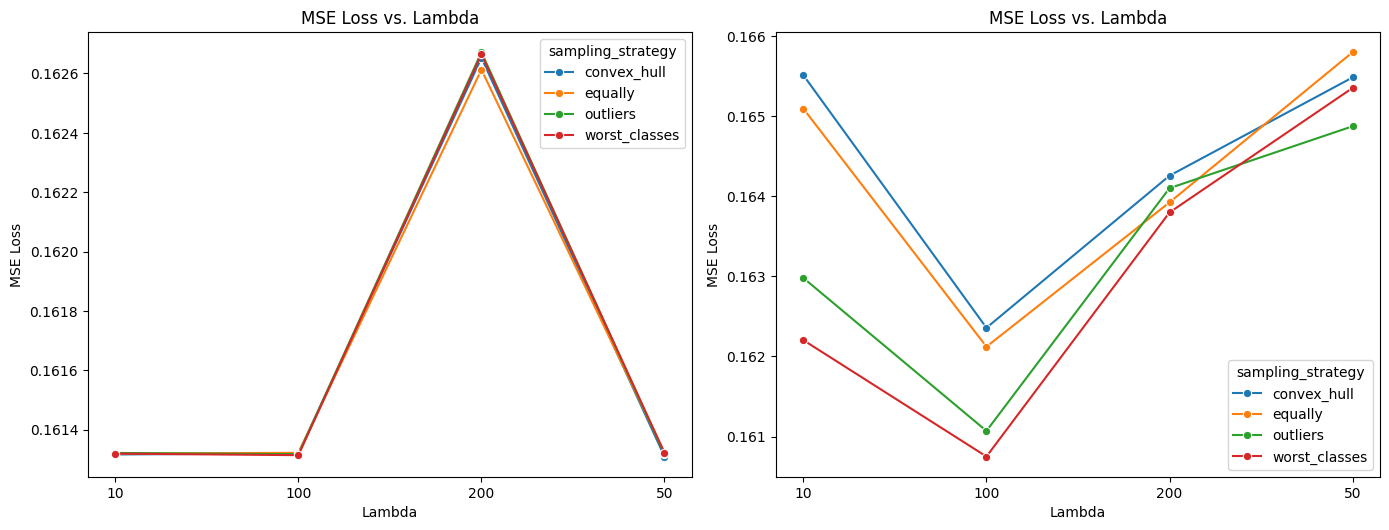

In [13]:
# Plotting
plt.figure(figsize=(14, 10))

filtered_for_sampler = results[results['mapping'] == 'Linear']

mean_mse_loss = filtered_for_sampler.groupby(['sampling_strategy', 'num_samples'])['MSE_loss'].mean().reset_index()
mean_mse_loss_transformed = filtered_for_sampler.groupby(['sampling_strategy', 'num_samples'])['MSE_loss_transformed'].mean().reset_index()


# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=mean_mse_loss, x='num_samples', y='MSE_loss', hue= "sampling_strategy", marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(2, 2, 2)
sns.lineplot(data=mean_mse_loss_transformed, x='num_samples', y='MSE_loss_transformed', hue= "sampling_strategy", marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')



# Show all plots
plt.tight_layout()
plt.show()